In [1]:
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cProfile
import pstats
%load_ext line_profiler

--------

### Set the number of resources

In [4]:
L = 40

### Define the ancestral phenotype (traits vector)

In [5]:
anc_phenotype = utils.random_matrix(shape=(1, L), mode='binomial')

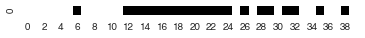

In [6]:
viz.matrix_plot(anc_phenotype)

### Define the system biochemistry (trait/resource interactions)

In [7]:
J = utils.random_matrix((L, L), 'tikhonov_sigmoid')

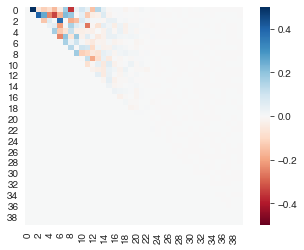

In [8]:
viz.matrix_plot(J)

### Parameterize and instantiate the Consumer-Resource System

In [9]:
anc_system = ConsumerResourceSystem(sigma=anc_phenotype, 
                                    b=1, k=1e10, c=0.1, chi=0.5, J=J, mu=1e-10,
                                    resource_consumption_mode='fast_resource_eq',
                                    resource_inflow_mode='none',
                                    threshold_min_rel_abundance=1e-6,
                                    N_init=1, R_init=1)

### Simulate dynamics

In [10]:
# just to pre-compile the dynamics njit function
# anc_system.dynamics(*((0,) + (np.zeros(L+L+1),) + anc_system.get_params()))

In [11]:
# anc_system.run(T=1000)

In [12]:
# %lprun -f anc_system.dynamics anc_system.run(T=1000)
# %lprun -f anc_system.handle_mutation_event anc_system.run(T=1000)

In [13]:
profiler = cProfile.Profile()
# %lprun -f anc_system.dynamics profiler.runcall(anc_system.run)
# %lprun -f ConsumerResourceSystem.growth_rate profile.runcall(anc_system.run)
# %lprun -f anc_system.event_low_abundance profiler.runcall(anc_system.run)
%lprun -f TypeSet.add_type profiler.runcall(anc_system.run)
# %lprun -f TypeSet.generate_mutant_set profiler.runcall(anc_system.run)

*** KeyboardInterrupt exception caught in code being profiled.00)]	

Timer unit: 1e-06 s

Total time: 67.7254 s
File: /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/type_set.py
Function: add_type at line 226

Line #      Hits         Time  Per Hit   % Time  Line Contents
   226                                               def add_type(self, type_set=None, sigma=None, b=None, k=None, eta=None, l=None, g=None, c=None, chi=None, mu=None, index=None, parent_index=None, parent_id=None):
   227      3068       5588.0      1.8      0.0          new_type_idx = index if index is not None else self.num_types # default to adding to end of matrices
   228      3068       5261.0      1.7      0.0          ref_type_idx = new_type_idx - 1
   229      3068       3291.0      1.1      0.0          parent_idx   = np.where(self.type_ids==parent_id)[0] if parent_id is not None else parent_index
   230                                                   #----------------------------------
   231      3068       3036.0      1.0      0.0      

In [14]:
ps = pstats.Stats(profiler)
ps.sort_stats('cumtime')
ps.print_stats()

         3846181 function calls (3844634 primitive calls) in 421.668 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   15.838   15.838  421.668  421.668 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:181(run)
     2823    0.595    0.000  146.973    0.052 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:444(handle_mutation_event)
     1534    8.097    0.005  133.614    0.087 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:585(add_type)
    83880  124.604    0.001  124.604    0.001 {built-in method numpy.concatenate}
    33748  113.333    0.003  114.678    0.003 /usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:5143(insert)
     2823    0.958    0.000  100.514    0.036 /usr/local/lib/python3.8/site-packages/scipy/in

### Visualize results

In [15]:
type_colors = viz.color_types_by_phylogeny(anc_system.type_set, apply_palette_depth=1)

<AxesSubplot:>

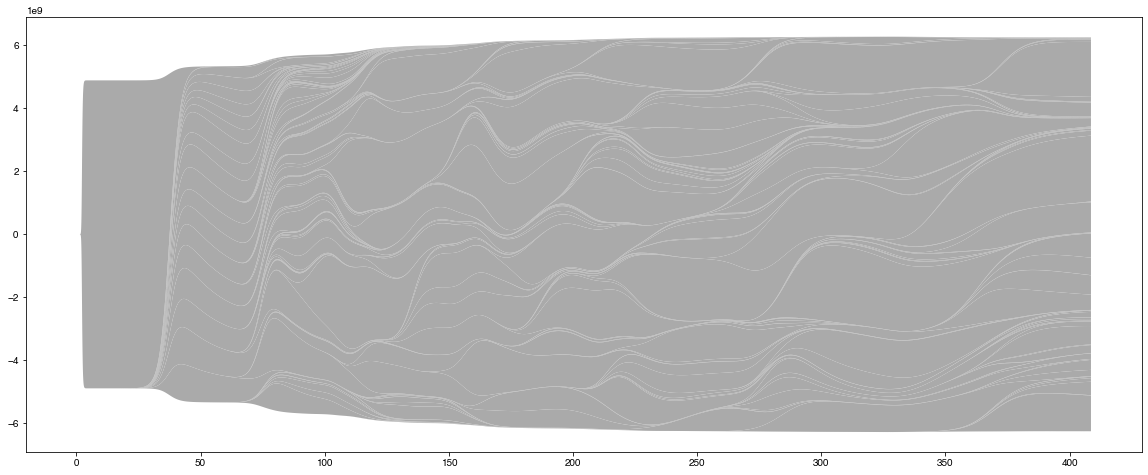

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(anc_system, ax=ax, type_colors=type_colors)

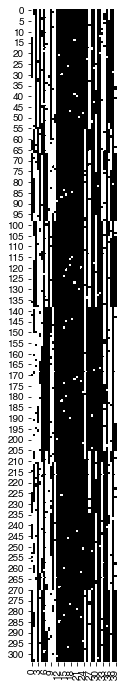

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.get_extant_type_set().sigma, ax=ax)

In [18]:
anc_system.type_set.mutant_set.sigma.shape

(61400, 40)

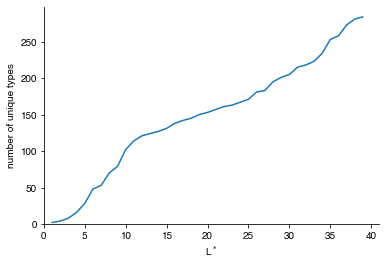

In [19]:
viz.Lstar_types_plot(anc_system)

In [20]:
N_end = anc_system.N_series[:,-1]
np.count_nonzero((N_end > 0) & (N_end < 1e4))

142

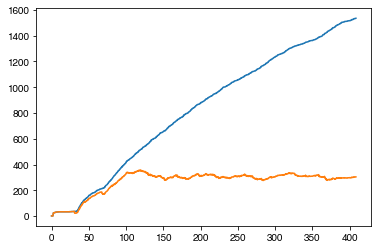

In [21]:
a = (anc_system.N_series > 0).argmax(axis=1)
n = []
for t_idx in range(anc_system.t_series.shape[0]):
    n.append(np.count_nonzero(a <= t_idx)) 
plt.plot(anc_system.t_series, n)
plt.plot(anc_system.t_series, (anc_system.N_series > 0).sum(axis=0))

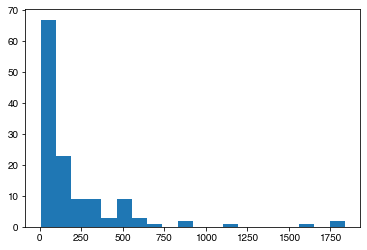

In [22]:
plt.hist(anc_system.N_series[(anc_system.N_series[:,-1]>0)&(anc_system.N_series[:,-1]<2000),-1], bins=20)
# plt.xlim((0,100))
plt.show()

In [23]:
# anc_system.mutant_fitnesses[(anc_system.N_series[:,-1] > 0) & (anc_system.N_series[:,-1] < 1e4)]
# ConsumerResourceSystem.growth_rate()
anc_system.N()

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
r = ConsumerResourceSystem.growth_rate(anc_system.N()[:, np.newaxis], anc_system.R(), anc_system.type_set.sigma, anc_system.type_set.b, anc_system.type_set.k, anc_system.type_set.eta, anc_system.type_set.l, anc_system.type_set.g, anc_system.type_set.energy_costs, anc_system.resource_set.omega, anc_system.resource_consumption_mode)

In [25]:
r[(anc_system.N() > 0) & (anc_system.N() < 1e4)] - np.mean(r[r > 0])

array([ 0.04554115, -0.03213465, -0.03378605,  0.04388975,  0.07349536,
        0.09971412, -0.03378605, -0.03378606, -0.03378606, -0.03378605,
       -0.03378605, -0.03378605,  0.09244996,  0.08714169, -0.03378605,
       -0.03378605, -0.03378605, -0.03378606,  0.06879824,  0.08364994,
       -0.03822926, -0.03822926,  0.07714804,  0.03944653, -0.03822926,
       -0.03822928,  0.0887931 ,  0.06905215, -0.03822926, -0.03822926,
       -0.08248293,  0.04494672, -0.08248293, -0.07652794,  0.06901017,
       -0.05723447, -0.05723449,  0.06938046, -0.05723447, -0.05723446,
       -0.05723447, -0.05723447, -0.05723447,  0.07634451, -0.06542995,
        0.13499311,  0.10778818, -0.04181438, -0.04181439, -0.03616901,
       -0.03616902, -0.03616901, -0.03616902,  0.08475873, -0.03616903,
       -0.03616902, -0.03616902, -0.03616902, -0.03616902, -0.03616903,
       -0.03616902,  0.11462602,  0.09039441,  0.08040076, -0.03497654,
       -0.03497654, -0.03497655,  0.10898065,  0.09227191, -0.01

In [26]:
r[r<0]

array([-1.28530487, -1.20928366, -1.09390636, ..., -1.02720455,
       -1.20928366, -1.20928367])

In [27]:
anc_system.type_set.sigma.shape

(1535, 40)

In [28]:
a = np.where(anc_system.N_series > 0)

In [29]:
anc_system.get_extant_types()


array([ 221,  224,  225,  226,  228,  231,  234,  235,  238,  240,  241,
        242,  243,  244,  245,  246,  247,  248,  249,  250,  251,  252,
        253,  254,  255,  256,  257,  258,  259,  260,  261,  262,  263,
        264,  265,  266,  267,  268,  272,  273,  274,  275,  276,  277,
        278,  279,  280,  281,  282,  283,  284,  285,  286,  288,  289,
        290,  373,  375,  377,  379,  380,  383,  387,  390,  392,  393,
        431,  547,  553,  554,  558,  559,  562,  563,  564,  579,  596,
        598,  603,  606,  607,  608,  609,  610,  611,  612,  613,  614,
        615,  616,  617,  618,  619,  620,  621,  626,  627,  630,  631,
        841,  843,  845,  846,  847,  848,  849,  862,  864,  866,  873,
        875,  876,  880,  882,  883,  884,  885,  886,  887,  888,  889,
        890,  891,  892,  893,  894,  895,  896,  897,  898,  899,  900,
        901,  902,  903,  904,  905,  906,  907,  968,  974,  975,  976,
        977,  978,  979,  980,  981,  982,  983,  9

In [30]:
1e3/1e10

1e-07